# EasyEdit Example with **IKE**
> Tutorial author: Ting Lu(<luting1@shanghaitech.edu.cn>) and Bozhong Tian(<tbozhong@zju.edu.cn>)
> 
In this tutorial, we use `IKE` to edit `gpt2` ans `LlaMA` model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.

This tutorial uses `Python3.9`.

# Model Editing
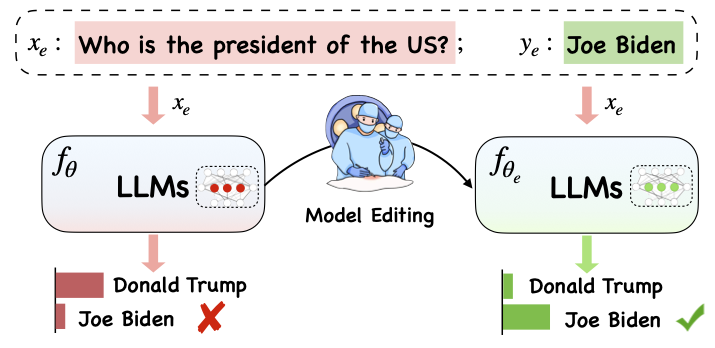

Deployed models may still make unpredictable errors. For example, Large Language Models (LLMs) notoriously *hallucinate*, *perpetuate bias*, and *factually decay*, so we should be able to adjust specific behaviors of pre-trained models.

**Model editing** aims to adjust an initial base model's $(f_\theta)$ behavior on the particular edit descriptor $[x_e, y_e]$, such as:
- $x_e$: "Who is the president of the US?
- $y_e$: "Joe Biden."

efficiently without influencing the model behavior on unrelated samples. The ultimate goal is to create an edited model$(f_\theta’)$.

# Editing Scope
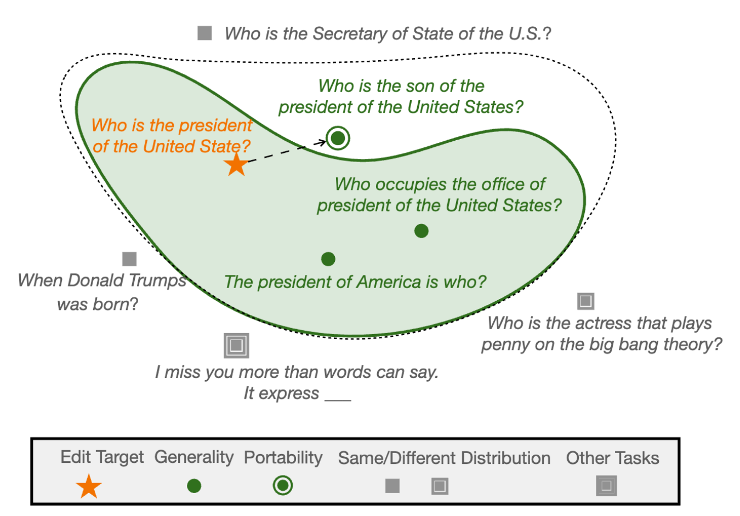

The model editing process generally impacts the predictions for a broad set of inputs **that are closely** associated with the edit example, called the **editing scope**.


A successful edit should adjust the model’s behavior within the editing scope while remaining unrelated inputs(as below formula).


$f_{\theta_{e}}(x) = \begin{cases}
y_e & \text{if } x \in I(x_e,y_e) \\
f_{\theta}(x) & \text{if } x \in O(x_e, y_e) \end{cases}$

In addition to this, the performance of model editing should be measured from multiple dimensions:

- `Reliability`: the success rate of editing with a given editing description
- `Generalization`: the success rate of editing **within** the editing scope
- `Locality`: whether the model's output changes after editing for unrelated inputs
- `Portability`: the success rate of editing for factual reasoning(one hop, synonym, one-to-one relation)
- `Efficiency`: time and memory consumption required during the editing process


# Method: **IKE**

Paper: [Can We Edit Factual Knowledge by In-Context Learning?](https://arxiv.org/abs/2305.12740)

**IKE** (In-context Knowledge Editing), is a way of editing factual knowledge in large language models **without modifying their parameters**, but by **providing different types of natural language demonstrations** as part of the input.  
It can achieve competitive knowledge editing performance **with less computation overhead and side effects**, as well as better scalability and interpretability.

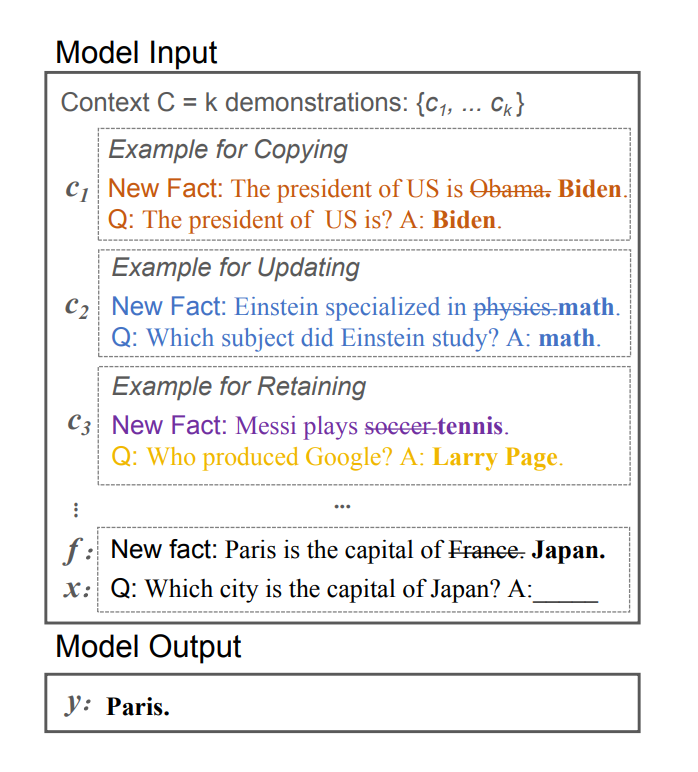

## Prepare the runtime environment

In [1]:
## Clone Repo
!git clone https://github.com/zjunlp/EasyEdit
%cd EasyEdit
!ls

/mnt/8t/xkw/EasyEdit
colab_requirements.txt	edit.py   LICENSE	      requirements.txt
demo			examples  logs		      results
Dockerfile		figs	  multimodal_edit.py  tutorial-notebooks
easyeditor		hparams   README.md	      tutorial.pdf


In [ ]:
!apt-get install python3.9

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9 python3.9-minimal
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 5,030 kB of archives.
After this operation, 19.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-minimal amd64 3.9.17-1+focal1 [805 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9-minimal amd64 3.9.17-1+focal1 [2,064 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-stdlib amd64 3.9.17-1+focal1 [1,666 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9 amd64 3.

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3

There are 3 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.10   2         auto mode
  1            /usr/bin/python3.10   2         manual mode
  2            /usr/bin/python3.8    1         manual mode
  3            /usr/bin/python3.9    1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 3
update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in manual mode


In [ ]:
!apt-get install python3-pip
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-pip python3-setuptools python3-wheel
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,389 kB of archives.
After this operation, 4,933 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python-pip-whl all 20.0.2-5ubuntu1.9 [1,805 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 python3-setuptools all 45.2.0-1ubuntu0.1 [330 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-wheel all 0.34.2-1ubuntu0.1 [23.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-pip all 20.0.2-5ubuntu1.9 [231 kB]
Fetched 2,389 kB in 1s (1,

In [2]:
!pip list

Package                  Version
------------------------ ----------
accelerate               1.0.1
aiohappyeyeballs         2.4.3
aiohttp                  3.10.10
aiosignal                1.3.1
antlr4-python3-runtime   4.8
asttokens                2.4.1
async-timeout            4.0.3
attrs                    24.2.0
blessed                  1.20.0
certifi                  2024.8.30
charset-normalizer       3.4.0
click                    8.1.7
cmake                    3.30.5
comm                     0.2.2
cycler                   0.12.1
datasets                 1.18.3
debugpy                  1.8.7
decorator                5.1.1
dill                     0.3.9
einops                   0.4.0
exceptiongroup           1.2.2
executing                2.1.0
fairscale                0.4.13
filelock                 3.16.1
fonttools                4.54.1
frozenlist               1.5.0
fsspec                   2024.10.0
gpustat                  1.1
higher                   0.2.1
huggingface-hub   

## Config Method Parameters


```python
# For IKE hparams:
alg_name: "IKE"
model_name: "gpt2" or "llama-7B"
sentence_model_name: "all-MiniLM-L6-v2"
device: 0
results_dir: "./results"

k: 32
```



In [1]:
!pip install matplotlib
!pip install sentence_transformers

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple


## Import modules & Run

In [1]:
%cd ..

/mnt/8t/xkw/EasyEdit


### For GPT Model

In [3]:
### For GPT Model
from easyeditor import BaseEditor
from easyeditor import IKEHyperParams
from easyeditor.models.ike.util import encode_ike_facts
from sentence_transformers import SentenceTransformer


prompts = ['Q: The president of the US is? A:',]
ground_truth = ['Donald Trump']
target_new = ['Joe Biden']
subject = ['president']
rephrase_prompts = ['The leader of the United State is']

# IKE need train_ds(For getting In-Context prompt)
train_ds = [
    {
        'prompt': 'Q: The president of the US is? A:',
        'target_new': 'Joe Biden',
        'rephrase_prompt': 'The leader of the United State is',
        'locality_prompt': 'The president of Russia is ',
        'locality_ground_truth': 'Putin'
    },
    {
        'prompt': 'Einstein specialized in',
        'target_new': 'physics',
        'rephrase_prompt': 'Einstein is good at',
        'locality_prompt': 'Q: Which subject did Newton specialize in? A: ',
        'locality_ground_truth': 'physics'

    },
    # add more if needed
]

In [4]:
hparams = IKEHyperParams.from_hparams('./hparams/IKE/gpt2-xl')
editor = BaseEditor.from_hparams(hparams)
# Initialize SentenceTransformer model
sentence_model = SentenceTransformer(hparams.sentence_model_name)
# Generate and save sentence embeddings
encode_ike_facts(sentence_model, train_ds, hparams)

metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    rephrase_prompts=rephrase_prompts, # new para
    target_new=target_new,
    subject=subject,
    train_ds=train_ds,
    sequential_edit=True
)

print(metrics)

2024-12-01 14:16:45,605 - easyeditor.editors.editor - INFO - Instantiating model
12/01/2024 14:16:45 - INFO - easyeditor.editors.editor -   Instantiating model
/mnt/8t/xkw/anaconda3/envs/EasyEdit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024-12-01 14:16:47,134 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/01/2024 14:16:47 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/01/2024 14:16:48 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device_name: cuda
12/01/2024 14:16:48 - INFO - sentence_transformer

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]12/01/2024 14:16:52 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device_name: cuda
12/01/2024 14:16:52 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: ./hugging_cache/all-MiniLM-L6-v2
/mnt/8t/xkw/anaconda3/envs/EasyEdit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


['New Fact: Q: The president of the US is? A: Joe Biden\nPrompt: Q: The president of the US is? A: Joe Biden\n\n', 'New Fact: Q: The president of the US is? A: Joe Biden\nPrompt: The leader of the United State is Joe Biden\n\n', 'New Fact: Q: The president of the US is? A: Joe Biden\nPrompt: The president of Russia is  Putin\n\n', 'New Fact: Einstein specialized in physics\nPrompt: Einstein is good at physics\n\n', 'New Fact: Einstein specialized in physics\nPrompt: Einstein specialized in physics\n\n', 'New Fact: Einstein specialized in physics\nPrompt: Q: Which subject did Newton specialize in? A:  physics\n\n', 'New Fact: Q: The president of the US is? A: Joe Biden\nPrompt: Q: The president of the US is? A: Joe Biden\n\n']


2024-12-01 14:16:53,162 - easyeditor.editors.editor - INFO - 0 editing: Q: The president of the US is? A: -> Joe Biden  

 {'pre': {'rewrite_acc': 0.5, 'locality': {}, 'portability': {}, 'rephrase_acc': 1.0}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Q: The president of the US is? A:', 'target_new': 'Joe Biden', 'ground_truth': 'Donald Trump', 'portability': {}, 'locality': {}, 'subject': 'president', 'rephrase_prompt': 'The leader of the United State is'}, 'post': {'rewrite_acc': 1.0, 'locality': {}, 'portability': {}, 'rephrase_acc': 1.0}}
12/01/2024 14:16:53 - INFO - easyeditor.editors.editor -   0 editing: Q: The president of the US is? A: -> Joe Biden  

 {'pre': {'rewrite_acc': 0.5, 'locality': {}, 'portability': {}, 'rephrase_acc': 1.0}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Q: The president of the US is? A:', 'target_new': 'Joe Biden', 'ground_truth': 'Donald Trump', 'portability': {}, 'locality': {}, 'subject': 'president', 'rephrase_prompt': 'The leader of the U

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 1.0}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0}}
[{'pre': {'rewrite_acc': 0.5, 'locality': {}, 'portability': {}, 'rephrase_acc': 1.0}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Q: The president of the US is? A:', 'target_new': 'Joe Biden', 'ground_truth': 'Donald Trump', 'portability': {}, 'locality': {}, 'subject': 'president', 'rephrase_prompt': 'The leader of the United State is'}, 'post': {'rewrite_acc': 1.0, 'locality': {}, 'portability': {}, 'rephrase_acc': 1.0}}]


In [5]:

from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('./hugging_cache/gpt2-xl',trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'
device = 1
model = GPT2LMHeadModel.from_pretrained('./hugging_cache/gpt2-xl',trust_remote_code=True).to(f'cuda:{device}')


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [8]:
ike_generation_prompts = [
    "The sky is red. \
    The color of the sky is red. \
    Q: What is the color of sky? A: Red. \
    Q: What color is the sky? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the US? A:",
]
generation_prompts = [
    "Q: What color is the sky? A:",
    "Q: Who is the president of the US? A:",
]

batch = tokenizer(generation_prompts, return_tensors='pt', padding=True)
edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(model.device),
    attention_mask=batch['attention_mask'].to(model.device),
    max_new_tokens=4,
    pad_token_id = tokenizer.eos_token_id
)
post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to(edited_model.device),
    attention_mask=edited_batch['attention_mask'].to(edited_model.device),
    max_new_tokens=4,
    pad_token_id = tokenizer.eos_token_id
)
print('*'*100)

generation_max_length = batch['input_ids'].shape[-1]
edited_max_length = edited_batch['input_ids'].shape[-1]
for i in range(len(ike_generation_prompts)):
    print(f'Pre-Edit  Output: {tokenizer.decode( pre_edit_outputs[i][generation_max_length :], skip_special_tokens=True)}')
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][edited_max_length :], skip_special_tokens=True)}')
    print('--'*50 )

****************************************************************************************************
Pre-Edit  Output:  It's blue.
Post-Edit Output:  Red.  
----------------------------------------------------------------------------------------------------
Pre-Edit  Output:  Barack Obama. Q
Post-Edit Output:  Biden.  
----------------------------------------------------------------------------------------------------


### For LlaMA Model

In [ ]:
from easyeditor import BaseEditor
from easyeditor import IKEHyperParams
from easyeditor.models.ike.util import encode_ike_facts
from sentence_transformers import SentenceTransformer


prompts = ['Q: The president of the US is? A:',]
ground_truth = ['Donald Trump']
target_new = ['Joe Biden']
subject = ['president']
rephrase_prompts = ['The leader of the United State is']

# IKE need train_ds(For getting In-Context prompt)
train_ds = [
    {
        'prompt': 'Q: The president of the US is? A:',
        'target_new': 'Joe Biden',
        'rephrase_prompt': 'The leader of the United State is',
        'locality_prompt': 'The president of Russia is ',
        'locality_ground_truth': 'Putin'
    },
    {
        'prompt': 'Einstein specialized in',
        'target_new': 'physics',
        'rephrase_prompt': 'Einstein is good at',
        'locality_prompt': 'Q: Which subject did Newton specialize in? A: ',
        'locality_ground_truth': 'physics'

    },
    # add more if needed
]

/mnt/tbozhong/anaconda3/envs/serac/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[{'case_id': 0, 'time': 0.25104260444641113, 'post': {'rewrite_acc': 1.0, 'locality': {}, 'portability': {}, 'rephrase_acc': 1.0}, 'pre': {'rewrite_acc': 0.5, 'portability': {}, 'rephrase_acc': 1.0}}]


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
Loading checkpoint shards: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s]
/mnt/tbozhong/anaconda3/envs/serac/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/mnt/tbozhong/anaconda3/envs/serac/lib/python3.8/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 50, but `max_length` is set to 30. This

****************************************************************************************************
Pre-Edit Outputs:  ['<unk><unk><unk>Q: What color is the sky? A: Blue. Q: What color is the grass? A: Green. Q: What', '<unk>Q: Who is the president of the US? A: Barack Obama B: George Bush C: Bill Clinton D: John F']
Post-Edit Outputs:  ['<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>The sky is red.     The color of the sky is red.     Q: What is the color of sky? A: Red.     Q: What color is the sky? A: Red', '<unk>The president of the US is Biden.     Q: Who is the president of the US? A: Biden.     Biden is the leader of the United State.     Q: Who is the president of the US? A: B']


In [ ]:
hparams = IKEHyperParams.from_hparams('./hparams/IKE/llama-7b')
editor = BaseEditor.from_hparams(hparams)
# Initialize SentenceTransformer model
sentence_model = SentenceTransformer(hparams.sentence_model_name)
# Generate and save sentence embeddings
encode_ike_facts(sentence_model, train_ds, hparams)

metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    rephrase_prompts=rephrase_prompts, # new para
    target_new=target_new,
    subject=subject,
    train_ds=train_ds,
    sequential_edit=True    
)
print(metrics)

In [ ]:
from transformers import LlamaForCausalLM
from transformers import LlamaTokenizer

device = 1
model = LlamaForCausalLM.from_pretrained('hugging_cache/llama-2-7b-chat').to(f'cuda:{device}')
tokenizer = LlamaTokenizer.from_pretrained('hugging_cache/llama-2-7b-chat')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = 'left'

In [ ]:

ike_generation_prompts = [
    "The sky is red. \
    The color of the sky is red. \
    Q: What is the color of sky? A: Red. \
    Q: What color is the sky? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the US? A:",
]
generation_prompts = [
    "Q: What color is the sky? A:",
    "Q: Who is the president of the US? A:",
]

batch = tokenizer(generation_prompts, return_tensors='pt', padding=True)
edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(model.device),
    attention_mask=batch['attention_mask'].to(model.device),
    max_new_tokens=4,
    pad_token_id = tokenizer.eos_token_id
)
post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to(edited_model.device),
    attention_mask=edited_batch['attention_mask'].to(edited_model.device),
    max_new_tokens=4,
    pad_token_id = tokenizer.eos_token_id
)
print('*'*100)

generation_max_length = batch['input_ids'].shape[-1]
edited_max_length = edited_batch['input_ids'].shape[-1]
for i in range(len(ike_generation_prompts)):
    print(f'Pre-Edit  Output: {tokenizer.decode( pre_edit_outputs[i][generation_max_length :], skip_special_tokens=True)}')
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][edited_max_length :], skip_special_tokens=True)}')
    print('--'*50 )
